In [2]:
import os
import json
#import torch
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from numpy.linalg import inv
import tensorflow as tf
import glob
import cv2

sway_folder = "/home/jovyan/data/metrabs-processed/sway"
root = f"{sway_folder}/sway61769"

### Get all video folder names. Don't us os.listdir(root) because it is too slow
with open(f"{sway_folder}/dataset61769.txt", "r") as f:
    vidnames = [line.strip() for line in f.readlines()]
    
def download_model(model_type):
    server_prefix = 'https://omnomnom.vision.rwth-aachen.de/data/metrabs'
    model_zippath = tf.keras.utils.get_file(
        origin=f'{server_prefix}/{model_type}.zip',
        extract=True, cache_subdir='models')
    model_path = os.path.join(os.path.dirname(model_zippath), model_type)
    return model_path

In [12]:
model = tf.saved_model.load(download_model('metrabs_eff2l_y4'))
skeleton='h36m_17'
joint_names = model.per_skeleton_joint_names[skeleton].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges[skeleton].numpy()
upper_indices = [0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

def metrab_inference(image, bbox=None, default_fov_degrees=55, skeleton='h36m_17'):
    if bbox is None:
        pred = model.detect_poses(image, default_fov_degrees=default_fov_degrees, skeleton=skeleton)
    else:
        keypoints = pred['poses2d'][0]
        xmin, ymin, xmax, ymax = 99999, 99999, -1, -1
        for kpt in keypoints:
            xmin = min(xmin, kpt[0])
            ymin = min(ymin, kpt[1])
            xmax = max(xmax, kpt[0])
            ymax = max(ymax, kpt[1])
        xmin = max(xmin - 20, 0)
        ymin = max(ymin - 80, 0)
        xmax = min(xmax + 20, image.shape[1])
        ymax = min(ymax + 20, image.shape[0])
        bbox = tf.convert_to_tensor(np.array([[xmin, ymin, xmax - xmin, ymax - ymin]], dtype=np.float32))
        pred = model.estimate_poses(image, bbox, default_fov_degrees=default_fov_degrees, skeleton=skeleton)
        pred['boxes'] = bbox
    
    pred = tf.nest.map_structure(lambda x: x.numpy(), pred)  # convert tensors to numpy arrays

    return pred['poses3d'], pred['poses2d'], pred['boxes']

def metrab_inference_batch(image, default_fov_degrees=55, skeleton='h36m_17'):
    pred = model.detect_poses_batched(image, default_fov_degrees=default_fov_degrees, skeleton=skeleton)
    pred = tf.nest.map_structure(lambda x: x.numpy(), pred)  # convert tensors to numpy arrays

    return pred['poses3d'], pred['poses2d'], pred['boxes']

In [4]:
def visualize(image, keypoint_2d, pose3d, bbox=None, _keypoint_2d=None):
    h, w, _ = image.shape
    plt.clf()
    fig = plt.figure(figsize=(16, 5))
    image_ax = fig.add_subplot(1, 4, 1)
    image_ax.imshow(image)
    
#     for j in range(keypoint_2d.shape[0]):
#         image_ax.plot(keypoint_2d[j, 0], keypoint_2d[j, 1], "o", markersize=3, color="orange")
    
    for jj, (i_start, i_end) in enumerate(joint_edges):
        image_ax.plot(*zip(keypoint_2d[i_start], keypoint_2d[i_end]), marker='o', markersize=2)
    image_ax.scatter(*keypoint_2d.T, s=3)
    
    if _keypoint_2d is not None:
        for joint2d in _keypoint_2d:
            x = joint2d['u'] * w
            y = joint2d['v'] * h
            image_ax.plot(x, y, "o", markersize=3, color="white", alpha=joint2d['confidence'])
        
    if bbox is not None:
        min_x = bbox[0]
        min_y = bbox[1]
        max_x = bbox[0] + bbox[2]
        max_y = bbox[1] + bbox[3]
        image_ax.plot([min_x, max_x, max_x, min_x, min_x], [min_y, min_y, max_y, max_y, min_y])

    deg = 5
    views = [(deg, deg - 90), (deg, deg), (90 - deg, deg - 90)]
    _pose3d = pose3d.copy()
    _pose3d[..., 1], _pose3d[..., 2] = _pose3d[..., 2], - _pose3d[..., 1]
    for vv, view in enumerate(views):
        pose_ax = fig.add_subplot(1, 4, vv + 2, projection='3d')
        pose_ax.view_init(*view)
        pose_ax.set_xlim3d(-1000, 1000)
        pose_ax.set_zlim3d(-1000, 1000)
        pose_ax.set_ylim3d(800, 3000)
        
        for jj, (i_start, i_end) in enumerate(joint_edges):
            pose_ax.plot(*zip(_pose3d[i_start], _pose3d[i_end]), marker='o', markersize=2)
        pose_ax.scatter(*_pose3d.T, s=2)
    plt.show()
    return

In [34]:
def find_intrinsics(pose3d, pose2d, cx, cy):
    if len(pose3d.shape) == 3:
        _pose3d = pose3d.reshape(-1, 3)
        _pose2d = pose2d.reshape(-1, 2)
    elif len(pose3d.shape) == 2:
        _pose3d = pose3d.copy()
        _pose2d = pose2d.copy()
    else:
        _pose3d = pose3d.reshape(1, 3)
        _pose2d = pose2d.reshape(1, 2)
    
    # Convert the 3D pose to homogeneous coordinates
    pose3d_homo = _pose3d / _pose3d[..., -1:]

    # Construct the linear equation matrix A
    A = np.zeros((2 * pose3d_homo.shape[0], 2))
    for i in range(pose3d_homo.shape[0]):
        A[2 * i, 0] = pose3d_homo[i, 0]
        A[2 * i + 1, 1] = pose3d_homo[i, 1]
    
    B = _pose2d - np.array([[cx, cy]])
    B = B.flatten()
    
    # Solve the linear system using least squares
    x, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
    fxx, fyy = x
    
    intrinsics = np.eye(3)
    intrinsics[0, 0] = fxx
    intrinsics[1, 1] = fyy
    intrinsics[:2, 2] = [cx, cy]
    return intrinsics

In [5]:
vidname = np.random.choice(vidnames)
folderpath = os.path.join(root, vidname)
imagefiles = [f for f in sorted(os.listdir(os.path.join(root, vidname, "images"))) if f.endswith(".jpg")]
with open(os.path.join(folderpath, "keypts2d.json"), "r") as f:
    kpt_params = json.load(f)
keypoints = kpt_params["key_points"]

In [32]:
frame_id = np.random.randint(0, len(imagefiles))
imagefile = imagefiles[frame_id]

image = tf.image.decode_jpeg(tf.io.read_file(os.path.join(folderpath, "images", imagefile)))
pose3d, pose2d, bbox = metrab_inference(image)


<Figure size 432x288 with 0 Axes>

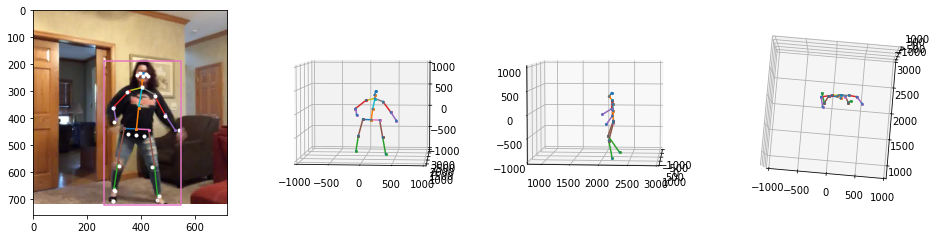

In [7]:
_keypoint_2d = keypoints[str(frame_id)] if frame_id < len(keypoints) else None
visualize(image.numpy(), pose2d[0], pose3d[0], bbox[0], _keypoint_2d)

In [41]:
### Start processing metrab annotations

for vidname in tqdm(vidnames[-19:]):
    folderpath = os.path.join(root, vidname)
    imagefiles = [f for f in sorted(os.listdir(os.path.join(root, vidname, "images"))) if f.endswith(".jpg")]
    metrab_dir = os.path.join(root, vidname, "metrab_annotations")
    os.makedirs(metrab_dir, exist_ok=True)
    
    poses3d_path = os.path.join(metrab_dir, "poses3d.npy")
    poses2d_path = os.path.join(metrab_dir, "poses2d.npy")
    bbox_path = os.path.join(metrab_dir, "bbox.npy")
    intrinsics_path = os.path.join(metrab_dir, "intrinsics.npy")
    extrinsics_path = os.path.join(metrab_dir, "extrinsics.npy")

    n_frames = len(imagefiles)
    pose3d_seq = {}
    pose2d_seq = {}
    bbox_seq = {}
    
    ### Doing batch inference !!!
    image_tensors = []
    for j, imagefile in enumerate(imagefiles[::5]):
        image = tf.image.decode_jpeg(tf.io.read_file(os.path.join(folderpath, "images", imagefile)))
        h, w, _ = image.shape
        image_tensors.append(image)
    
    image_batch = tf.stack(image_tensors)
    pose3d_batch, pose2d_batch, bbox_batch = metrab_inference_batch(image_batch)

    for i, imagefile in enumerate(imagefiles[::5]):
        imagefilename = imagefile.replace('.jpg', '')
        if len(bbox_batch[i]) == 0:
            continue
        if bbox_batch[i][0][-1] < 0.8:
            continue
            
        pose3d_seq[imagefilename] = np.array(pose3d_batch[i][0])
        pose2d_seq[imagefilename] = np.array(pose2d_batch[i][0])
        bbox_seq[imagefilename] = np.array(bbox_batch[i][0])
    
    poses3d = np.array([pp for pp in pose3d_seq.values()])
    poses2d = np.array([pp for pp in pose2d_seq.values()])
    intrinsics = find_intrinsics(poses3d, poses2d, w/2, h/2)
    np.save(poses3d_path, pose3d_seq)    
    np.save(poses2d_path, pose2d_seq)
    np.save(bbox_path, bbox_seq)
    np.save(intrinsics_path, intrinsics)
    np.save(extrinsics_path, np.eye(4))
    

100%|██████████| 19/19 [01:56<00:00,  6.14s/it]
